<h1><center>CommonLit Readability Prize</center></h1>
<h1><center>ONE STOP: Understanding + EDA + BERT</center></h1>

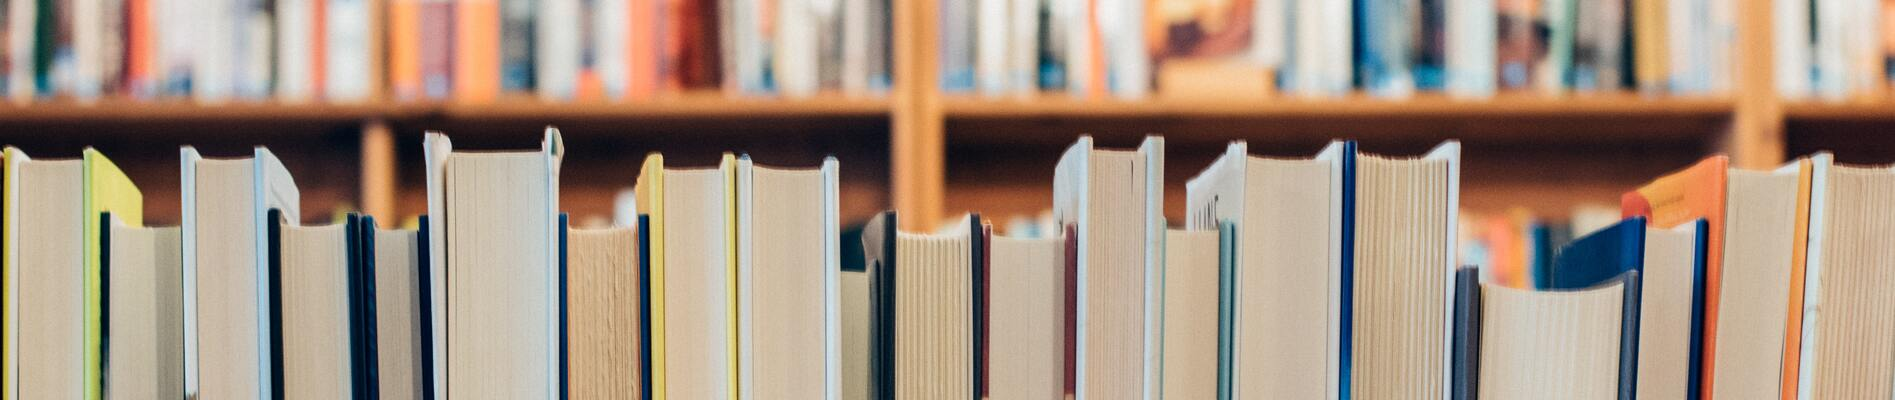

##### In this notebook I will drive you through all the important steps required to understand and complete this competition.

##### If you find this notebook helpful. Please Upvote.

<h2><center>Understand the Problem</center> </h2>


#### GOAL
The objective of this Competition is to build a Machine Learning model to rate the complexity of reading passages for grade 3-12 classroom use based on pattern extracted from analysing <b>6 descriptive features.</b>

In simple words, we are given training.csv file in which we have (among other) 2 columns: excerpt and target, we will have to train Machine Learning model(s) that can approximate the relationship between excerpt and the target.

<h4>Descriptive Features</h4>
<ol>
  <li>id : unique ID for excerpt</li>
  <li>url_legal : URL of source</li>
  <li>license : license of source material</li>
  <li>excerpt : text to predict reading ease of</li>
  <li>target : reading ease</li>
  <li>standard_error : measure of spread of scores among multiple raters for each excerpt</li>
</ol>

<h4>Evaluation Metrics</h4>
Submissions are scored on the root mean squared error <b>RMSE</b>

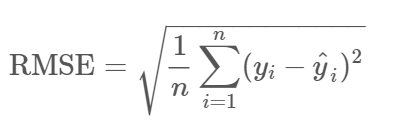

where  is the predicted value,  is the original value, and  is the number of rows in the test data.

<h2><center>Exploratory Data Analysis (EDA) </center></h2>

In [ ]:
import numpy as np
import pandas as pd
import plotly
import plotly.graph_objs as go
import os
import re
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import nltk
from wordcloud import WordCloud
# nltk.download('stopwords')
from nltk.corpus import stopwords
stop=stopwords.words('english')
from nltk.stem import WordNetLemmatizer
from textblob import TextBlob,Word
from collections import Counter
import string
import plotly.figure_factory as ff
import plotly.io as pio
from plotly.subplots import make_subplots
import plotly.express as px
from plotly.offline import iplot, init_notebook_mode
import cufflinks as cf
import plotly.figure_factory as ff 
from plotly.offline import iplot
from plotly import tools
colors = px.colors.qualitative.Prism
pio.templates.default = "plotly_white"


#### Read Data

##### Train Data

In [ ]:
train_df=pd.read_csv('../input/commonlitreadabilityprize/train.csv')
train_df.head()

In [ ]:
train_df.shape

In [ ]:
train_df.isna().sum()

##### In two columns - 'url_legal' and 'license' have missing values. Rest other columns have no missing values.

In [ ]:
train_df.nunique()

##### Here we can see that 'url_legal' and 'license' have repeating values while other columns have all values unique. 

##### Test Data

In [ ]:
test_df=pd.read_csv('../input/commonlitreadabilityprize/test.csv')
test_df.head()

In [ ]:
test_df.shape

##### Sample Submission Data

In [ ]:
sample_submission_df=pd.read_csv('../input/commonlitreadabilityprize/sample_submission.csv')
sample_submission_df.head()

<h3>Data Preprocessing</h3>

Text processing is an import step in NLP. It transforms text into more digestable form so that ML algorithms can perform better. We will apply 'data_preprocessing' function on 'excerpt' column.
<h4>Preprocessing Steps</h4>
<ol>
  <li>Lowercasing</li>
  <li>Removing Stop Words</li>
  <li>Removing Digits</li>
  <li>Removing URLs, HTML Tags</li>
</ol>


In [ ]:
to_replace_by_space = re.compile('[/(){}\[\]|@,;]')
punctuation = re.compile(f'([{string.punctuation}“”¨«»®´·º½¾¿¡§£₤‘’])')
bad_symbols = re.compile('[^0-9a-z #+_]')
stopwords = set(stopwords.words('english'))

def data_preprocessing(text):
    text = text.lower() 
    text = re.sub(punctuation, '',text)
    text = re.sub(to_replace_by_space, " ", text) 
    text = re.sub(bad_symbols, "", text)
    text = " ".join([word for word in text.split(" ") if word not in stopwords]) 
    text = re.sub(' +', ' ', text)
    return text

In [ ]:
train_df['excerpt'] = train_df['excerpt'].apply(data_preprocessing)

#### Now lets do some Data Visualization to get more insights out of data. For this, first we will define two function (bar plot function and histogram function) to make the plotting easier.


In [ ]:
# Bar Plot Function
def bar_plot_func(data_frame,x,x_title,y,title,colors=None,text=None,color_discrete_sequence=['mediumaquamarine']):
    fig=px.bar(x=x,y=y,text=text,labels={x:x_title.title()},data_frame=data_frame,
               color=colors,barmode='group',template='simple_white',
               color_discrete_sequence=color_discrete_sequence)
    texts=[data_frame[col].values for col in y]
    for i, t in enumerate(texts):
        fig.data[i].text = t
        fig.data[i].textposition = 'inside'    
    fig['layout'].title=title
    for trace in fig.data:
        trace.name = trace.name.replace('_',' ').title()
    fig.update_yaxes(tickprefix="", showgrid=True)
    fig.show()


# Histogram Function
def hist_plot_func(data_frame,x,title,color_discrete_sequence=['indianred']):
    fig=px.histogram(x=data_frame[x],color_discrete_sequence=color_discrete_sequence,opacity=0.8)
    fig['layout'].title=title
    fig.update_yaxes(tickprefix="", showgrid=True)
    fig.show()

In [ ]:
title='Target Column distribution'
hist_plot_func(train_df, 'target' ,title)

In [ ]:
temp = train_df['license'].dropna()
temp = temp.value_counts().to_frame().reset_index()
title = 'Unique licenses Count'
bar_plot_func(temp,'index','License',['license'],title=title)

In [ ]:
title='Standard Error Distribution'
hist_plot_func(train_df, 'standard_error',title,color_discrete_sequence=['skyblue'])

In [ ]:
# Unique URLs
url_unique_list = train_df['url_legal'].dropna().apply(lambda x : re.findall('https?://([A-Za-z_0-9.-]+).*',x)[0]).unique()
print(url_unique_list)

In [ ]:
# Unique Site Counts
url_count = {}
for sent in train_df['url_legal'].dropna().values:
    url = re.findall('https?://([A-Za-z_0-9.-]+).*',sent)[0]
    if url in url_count:
        url_count[url] += 1
    else:
        url_count[url] = 1
    
url_count_df = pd.DataFrame(data=url_count.items())
url_count_df = url_count_df.sort_values(by=1,ascending=False).rename(columns={0:'Site',1:'Count'})
url_count_df

In [ ]:
title = 'Unique Sites count'
bar_plot_func(url_count_df, 'Site','Site Name',['Count'],title=title,color_discrete_sequence=['coral'])

### Unigrams

In [ ]:
# 1. Create list of words
text= ' '.join(t for t in train_df['excerpt'])
words_list= text.split()
# 2. Create word to count dictionary
word_freq= {}
for word in set(words_list):
    word_freq[word]= words_list.count(word)  
# 3.Sorting the dictionary 
word_freq = dict(sorted(word_freq.items(), reverse=True, key=lambda item: item[1]))
# 4. Sort the data and put it in a data frame for the visualization
word_freq_temp = dict(itertools.islice(word_freq.items(), 25))
word_freq_df = pd.DataFrame(word_freq_temp.items(),columns=['word','count']).sort_values('count',ascending=False)

In [ ]:
bar_plot_func(word_freq_df.reset_index(),'word','Words',['count'],title='Top 20 frequent words',color_discrete_sequence=['dimgray'])

In [ ]:
def wordcloud(text,stopwords,ngram=1):
    # text: if ngram>1, text should be a dictionary
    wordcloud = WordCloud(width=1400, 
                          height=800,
                          random_state=2021,
                          background_color='black',
                          stopwords=stop)
    if ngram ==1:
        wordc = wordcloud.generate(' '.join(text))
    else:
        wordc = wordcloud.generate_from_frequencies(text)
    plt.figure(figsize=(20,10), facecolor='k')
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.tight_layout(pad=0)
    
wordcloud(train_df['excerpt'],stop)

### Bigrams

In [ ]:
from nltk.util import ngrams    

def get_n_grans_count(text, n_grams, min_freq):
    output = {}
    tokens = nltk.word_tokenize(text)

    #Create the n_gram
    if n_grams == 2:
        gs = nltk.bigrams(tokens)
        
    elif n_grams == 3:
        gs = nltk.trigrams(tokens)

    else:
        return 'Only 2_grams and 3_grams are supported'
    
    #compute frequency distribution for all the bigrams in the text
    fdist = nltk.FreqDist(gs)
    for k,v in fdist.items():
        if v > min_freq:
            index = ' '.join(k)
            output[index] = v
    
    return output

In [ ]:
two_grams = get_n_grans_count(text, n_grams=2, min_freq=10)
two_grams_df = pd.DataFrame(data=two_grams.items())
two_grams_df = two_grams_df.sort_values(by=1,ascending=False).rename(columns={0:'Two grams',1:'Count'})
two_grams_df

In [ ]:
bar_plot_func(two_grams_df.iloc[:20],'Two grams','Two grams',['Count'],title='Top 20 frequent bigram',color_discrete_sequence=['dimgray'])

In [ ]:
two_grams_temp = {j.replace(' ','_'):k for j,k in two_grams.items()}
wordcloud(two_grams_temp,stop,ngram=2)

### Trigrams

In [ ]:
three_grams = get_n_grans_count(text, n_grams=3, min_freq=0)
three_grams_df = pd.DataFrame(data=three_grams.items())
three_grams_df = three_grams_df.sort_values(by=1,ascending=False).rename(columns={0:'Three grams',1:'Count'})
three_grams_df

In [ ]:
bar_plot_func(three_grams_df.iloc[:20],'Three grams','Three grams',['Count'],title='Top 20 frequent trigram',color_discrete_sequence=['dimgray'])

In [ ]:
three_grams_temp = {j.replace(' ','_') : k for j, k in three_grams.items()}
wordcloud(three_grams_temp,stop,ngram=3)

<h2><center>Model : BERT & PyTorch</center></h2>

In [ ]:
# Libraries
import torch 
from torch import nn 
import torch.nn.functional as F
import numpy as np 
import pandas as pd 
from torch.utils.data import Dataset, DataLoader
import pytorch_lightning as pl 
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn import model_selection
import transformers
from transformers import get_linear_schedule_with_warmup, AdamW

##### Train Data

In [ ]:
# As we have seen above in EDA that url_legal and license have around 90% missing value. 
# So we will drop those columns and use the remaing ones.

df = pd.read_csv("../input/commonlitreadabilityprize/train.csv",usecols=["id","excerpt","target"])
print("train shape",df.shape)
df.head()

##### Test Data

In [ ]:
# Similarly with test data.

test_df = pd.read_csv("../input/commonlitreadabilityprize/test.csv",usecols=["id","excerpt"])
test_df.head()

In [ ]:
#remove \n and replace \'s with 'sfrom the text
def prep_text(text_df):
    text_df = text_df.str.replace("\n","",regex=False) 
    return text_df.str.replace("\'s",r"s",regex=True).values
df["excerpt"] = prep_text(df["excerpt"])
test_df["excerpt"] = prep_text(test_df["excerpt"])

In [ ]:
# Max Word Count
max_words = df["excerpt"].apply(lambda x: len(x.split())).max()
print("maximum words in instance:",max_words)

##### Create Folds
Inspired By [Abhishek Thankur's Notebook](https://www.kaggle.com/abhishek/step-1-create-folds)

In [ ]:
def create_folds(data, num_splits):
    # we create a new column called kfold and fill it with -1
    data["kfold"] = -1
    
    # the next step is to randomize the rows of the data
    data = data.sample(frac=1).reset_index(drop=True)

    # calculate number of bins by Sturge's rule
    # I take the floor of the value, you can also
    # just round it
    num_bins = int(np.floor(1 + np.log2(len(data))))
    
    # bin targets
    data.loc[:, "bins"] = pd.cut(
        data["target"], bins=num_bins, labels=False
    )
    
    # initiate the kfold class from model_selection module
    kf = model_selection.StratifiedKFold(n_splits=num_splits)
    
    # fill the new kfold column
    # note that, instead of targets, we use bins!
    for f, (t_, v_) in enumerate(kf.split(X=data, y=data.bins.values)):
        data.loc[v_, 'kfold'] = f
    
    # drop the bins column
    data = data.drop("bins", axis=1)

    # return dataframe with folds
    return data

# read training data
df = pd.read_csv("../input/commonlitreadabilityprize/train.csv")

# create folds
df = create_folds(df, num_splits=5)

##### BERT Model Configurations

In [ ]:
# BERT Config
BATCH_SIZE = 16
EPOCHS = 15
NUM_TRAIN_STEPS = int((df.shape[0]/BATCH_SIZE)*EPOCHS)
NUM_WARMUP_STEPS = 0
FOLDS = df.kfold.unique()
NUM_FOLDS = df.kfold.nunique() 

In [ ]:
# RMSE
class RMSELoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.eps = 1e-8
        
    def forward(self,output,target):
        return torch.sqrt(F.mse_loss(output,target)+self.eps)

In [ ]:
class BertModel(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.model = transformers.AutoModel.from_pretrained("../input/bert-base-uncased")
        self.drop = nn.Dropout(0.5)
        self.fc = nn.Linear(768,1)
    def forward(self,inputs):
        out = self.model(**inputs)
        last_hiddens = out[0]
        out = self.drop(last_hiddens[:,0,:].squeeze(1))
        return self.fc(out)
    def configure_optimizers(self):
        no_decay = ['bias', 'LayerNorm.weight']
        optimizer_grouped_parameters = [
            {'params': [p for n, p in self.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
            {'params': [p for n, p in self.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
        ]
        optimizer = AdamW(optimizer_grouped_parameters, lr=5e-5)
        scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=NUM_WARMUP_STEPS, num_training_steps=NUM_TRAIN_STEPS)
        return [optimizer],[scheduler]
    def loss_fn(self,output,target):
        return RMSELoss()(output.view(-1),target.view(-1))
    def training_step(self,batch,batch_idx):
        inputs = batch["inputs"]
        labels = batch["label"]
        output = self(inputs)
        loss = self.loss_fn(output,labels)
        return loss
    def validation_step(self,batch,batch_idx):
        inputs = batch["inputs"]
        labels = batch["label"]
        output = self(inputs)
        loss = self.loss_fn(output,labels)
        self.log("val_loss",loss,prog_bar=True)

In [ ]:
# Tokenize Dataset and Dataloader
class BertDataset(Dataset):
    def __init__(self,texts,labels,max_len):
        super().__init__()
        self.texts = texts
        self.max_len = max_len
        self.labels = labels
        self.tokenizer = transformers.AutoTokenizer.from_pretrained("../input/bert-base-uncased")
    
    def __len__(self):
        return self.labels.shape[0]
    
    def __getitem__(self,idx):
        text = " ".join(self.texts[idx].split())
        label = self.labels[idx]
        inputs = self.tokenizer(text,return_tensors="pt",max_length = self.max_len, padding="max_length",truncation=True)
        return {
            "inputs":{"input_ids":inputs["input_ids"][0],
                      "token_type_ids":inputs["token_type_ids"][0],
                      "attention_mask":inputs["attention_mask"][0],},
            "label":torch.tensor(label,dtype=torch.float)
        }

In [ ]:
# Training
for fold in FOLDS:
    print("Fold :",fold)
    train_df, valid_df = df[df.kfold!=fold], df[df.kfold==fold]
    train_dataset = BertDataset(train_df.excerpt.values,train_df.target.values,max_len=max_words)
    valid_dataset = BertDataset(valid_df.excerpt.values,valid_df.target.values,max_len=max_words)
    train_dloader = DataLoader(train_dataset,batch_size=BATCH_SIZE,shuffle=True,num_workers=4)
    valid_dloader = DataLoader(valid_dataset,batch_size=BATCH_SIZE,shuffle=False,num_workers=4)
    bert_model = BertModel() 
    trainer = pl.Trainer(gpus=-1,max_epochs=EPOCHS,callbacks=[EarlyStopping(monitor="val_loss",mode="min")],checkpoint_callback=False)
    trainer.fit(model = bert_model,train_dataloader = train_dloader,val_dataloaders = valid_dloader)
    trainer.save_checkpoint(f"checkpoint_{fold}fold.ckpt")

In [ ]:
# Load Weights and Inference
prediction = np.zeros(test_df.shape[0]) 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
for fold in FOLDS:
    print("Fold:",fold)
    loaded_model = BertModel.load_from_checkpoint(f"./checkpoint_{fold}fold.ckpt",map_location=device)
    loaded_model.to(device)
    loaded_model.eval() 
    #using the same BertDataset module of train, here dummy labels are provided
    test_dataset = BertDataset(test_df.excerpt.values,labels = np.ones(test_df.shape[0]),max_len=max_words)
    test_dataloader = DataLoader(test_dataset,batch_size=BATCH_SIZE,shuffle=False,num_workers=4)
    output = []
    for batch in test_dataloader:
        x  = batch["inputs"]
        for key in x.keys():
            x[key] = x[key].to(device)
        assert x["input_ids"].is_cuda, f"data is not in model device({loaded_model.device.type})"
        out = loaded_model(x)
        output.extend(out.cpu().detach().numpy())
    prediction += np.hstack(output)

In [ ]:
test_df["target"] = prediction/NUM_FOLDS
sub = test_df.drop("excerpt",axis=1) 
sub.to_csv("submission.csv",index=False)

In [ ]:
sub.head()

## Refer my new notebook for better score model using Pytorch Lightining [RoBERTa](https://www.kaggle.com/harshsharma511/pytorch-lightining-roberta)